<a href="https://colab.research.google.com/github/sakurasakura1996/Pytorch-start-learning/blob/master/Dive_into_DL_pytorch_5_6_5_7_AlexNet_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 5.6.2 AlexNet
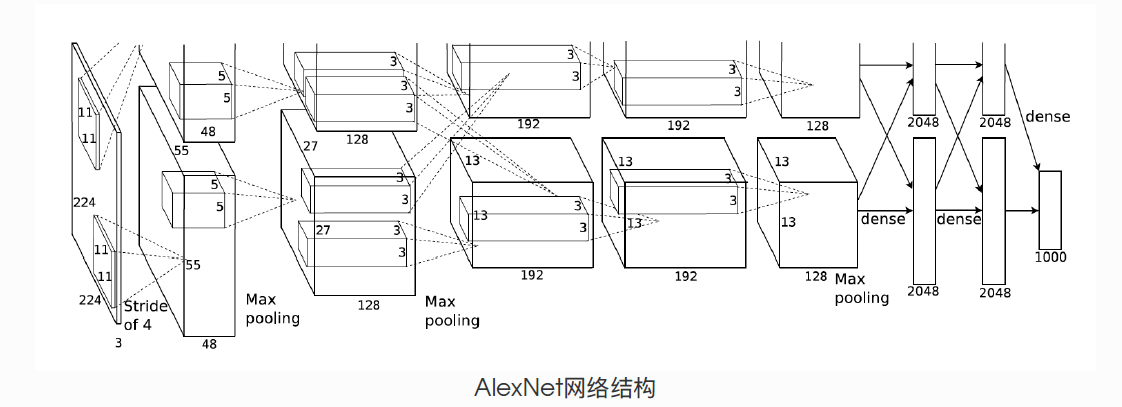
AlexNet与LeNet设计理念相似，但也有显著区别：
第一、与相对较小的LeNet相比，AlexNet包含8层变换，其中有5层卷积和2层全连接隐藏层，以及1个全连接输出层。
第二、AlexNet将sigmoid函数改成了ReLU激活函数
第三、AlexNet通过丢弃法来控制全连接层的模型复杂度。而LeNet并没有使用丢弃发
第四、AlexNet引入了大量的图像增广，如翻转、裁剪和颜色变化，从而进一步扩大数据集来缓解过拟合
下面实现稍微简化过的AlexNet


In [0]:
import time
import torch
import torchvision
from torch import nn, optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class AlexNet(nn.Module):
  def __init__(self):
    super(AlexNet,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1,96,11,4),  # 输入通道， 输出通道， kernel_size, stride， padding
        nn.ReLU(),
        nn.MaxPool2d(3,2),    # kernel_size,  stride
        nn.Conv2d(96, 256, 5, 1, 2),
        nn.ReLU(),
        nn.MaxPool2d(3, 2),
        nn.Conv2d(256, 384, 3, 1, 1),   # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道
        nn.ReLU(),   # 前两个卷积层后不使用池化层来减小输入的高和宽
        nn.Conv2d(384, 384, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(384, 256, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(3, 2)
    )
    # 这里的全连接层的输出个数比Lenet中的大数倍。使用丢弃层来缓解过拟合
    self.fc = nn.Sequential(
        nn.Linear(256*5*5, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        # 输出层  这里改掉，因为输出类别为10 而不是原来的1000
        nn.Linear(4096, 10),
    )
  def forward(self, img):
    feature = self.conv(img)
    output = self.fc(feature.view(img.shape[0],-1))
    return output

In [2]:
net = AlexNet()
print(net)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (

In [3]:
# 读取数据
# 这里我们还是使用Fashion-MNIST来演示。读取数据的时候我们额外做一步将图像高和宽扩大到Alex net使用的图像高和宽224.可通过torchvision.transforms.Resize实例来实现
# 我们在ToTensor实例前使用Resize实例，然后使用Compose实例来将这两个变换串联以方便调用
def load_data_fashion_mnist(batch_size, resize=None):
  trans = []
  if resize:
    trans.append(torchvision.transforms.Resize(size=resize))
  trans.append(torchvision.transforms.ToTensor())

  transform = torchvision.transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',train=True,transform=transform,download=True)
  mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',train=False,transform=transform,download=True)

  train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=4)
  test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=4)
  return train_iter, test_iter

batch_size = 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw
Processing...
Done!


In [4]:
print(type(train_iter))
print(len(train_iter))  # 这里len 可以理解为总共有 469个batch


<class 'torch.utils.data.dataloader.DataLoader'>
469


In [0]:
# 使用GPU来运算，下面来写evaluate_accuracy函数做修改。支持GPU
def evaluate_accuracy(data_iter, net, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
  acc_sum, n =0.0, 0
  with torch.no_grad():
    for X,y in data_iter:
      if isinstance(net, torch.nn.Module):
        net.eval()   # 评估模式，这回关闭dropout
        acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
        net.train()  # 改回训练模式
      else:
        if('is_training' in net.__code__.co_varnames):
          acc_sum += (net(X,is_training=False).argmax(dim=1) == y).float().sum().item()
        else:
          acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
      n += y.shape[0]
  return acc_sum / n

In [0]:
def train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
  net = net.to(device)
  print("training on ",device)
  loss = torch.nn.CrossEntropyLoss()
  batch_count = 0
  for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
    for X,y in train_iter:
      X = X.to(device)
      y = y.to(device)
      y_hat = net(X)
      l = loss(y_hat,y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
      train_l_sum += l.cpu().item()
      train_acc_sum +=(y_hat.argmax(dim=1) == y).sum().cpu().item()
      n += y.shape[0]
      batch_count +=1
    test_acc = evaluate_accuracy(test_iter, net)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f,time %.1f sec'% (epoch + 1, train_l_sum / batch_count,train_acc_sum / n, test_acc, time.time() - start))

In [0]:
# 训练
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

training on  cuda
epoch 1, loss 0.3319, train acc 0.877, test acc 0.885,time 77.7 sec
epoch 2, loss 0.1422, train acc 0.895, test acc 0.898,time 77.7 sec
epoch 3, loss 0.0856, train acc 0.906, test acc 0.897,time 77.5 sec
epoch 4, loss 0.0589, train acc 0.913, test acc 0.910,time 77.6 sec
epoch 5, loss 0.0437, train acc 0.919, test acc 0.914,time 77.7 sec


# 5.7 使用重复元素的网络 -> VGG 网络
AlexNet在LeNet的基础上增加了3个卷积层。VGG提出了可以通过重复使用简单的基础块来构建深度模型的思路
VGG块的组成规律是：连续使用数个相同的填充为１，窗口形状为３ｘ３的卷积层后接上一个步幅为２，窗口形状为２ｘ２的最大池化层。卷积层保持输入的高和宽不变，而池化层则对其减半。我们使用　vgg_block 函数来实现这个基础的VGG块，它可以指定卷积层的数量和输入输出通道数。
**对于给定的感受野（与输出有关的输入图片的局部大小），采用堆积的小卷积核优于采用大的卷积核，因为可以增加网络深度来保证学习更复杂的模式，而且代价还比较小（参数更少）。例如，在VGG中，使用了3个3x3的卷积核来代替7x7的卷积核，使用了2个3x3卷积核来代替5x5卷积核，这样做的主要目的是在保证具有相同感受野的条件下，提升了网络的深度，在一定程度上提升了神经网络的效果**

In [0]:
import time
import torch
from torch import nn, optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def vgg_block(num_convs, in_channels, out_channels):
  blk = []
  for i in range(num_convs):
    if i == 0:
      blk.append(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
    else:
      blk.append(nn.Conv2d(out_channels, out_channels,kernel_size=3, padding=1))
    blk.append(nn.ReLU())
  blk.append(nn.MaxPool2d(kernel_size=2, stride=2))  # 这里会使宽高减半
  return nn.Sequential(*blk)   # 这里要加 * 

In [0]:
# 5.7.2 VGG 网络
# VGG 网络也是前面是卷积层模块，后接全连接模块。卷积层模块是数个vgg_block模块，数量是一个超参数由变量 conv_arch定义。该变量指定了每个VGG块里卷积层个数和输入输出通道数
# 全连接模块则跟AlexNet中的一样。  现在我们构造一个VGG，他有5个卷积块，前两块使用单卷积层，而后3块使用双卷积层。第一块的输入输出通道分别是1（因为下面要使用的Fashion-MNIST数据的通道数为1）
# 和64，之后每次对输出通道数翻倍，直到变为512。因为这个网络使用了8个卷积层和3个全连接层，所以经常称为VGG-11
conv_arch = ((1,1,64),(1,64,128),(2,128,256),(2,256,512),(2,512,512))
# 经过5个vgg_block，宽高会减半5次，变成224/32 = 7
fc_features = 512*7*7   # c*w*h
fc_hidden_units = 4096   # 任意

In [0]:
class FlattenLayer(nn.Module):
  def __init__(self):
    super(FlattenLayer, self).__init__()
  def forward(self, x): # x shape: (batch, *, *, ...)
    return x.view(x.shape[0], -1)

In [0]:
def vgg(conv_arch, fc_features, fc_hidden_units=4096):
  net = nn.Sequential()
  for i, (num_convs, in_channels, out_channels) in enumerate(conv_arch):
    # 每经过一个vgg_block都会使宽高减半
    net.add_module("vgg_block_"+str(i+1),vgg_block(num_convs, in_channels, out_channels))
  net.add_module("fc",nn.Sequential(
      FlattenLayer(),
      nn.Linear(fc_features, fc_hidden_units),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(fc_hidden_units, fc_hidden_units),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(fc_hidden_units,10)
  ))
  return net

In [12]:
# 下面构造一个高和宽均为224的单通道数据样本来观察每一层的输出形状
net = vgg(conv_arch, fc_features,fc_hidden_units)
X = torch.rand(1,1,224,224)

print(net.named_children())
# named_children获取一级子模块及其名字（named_modules会返回所有子模块，包括子模块的子模块
for name, blk in net.named_children():
  X = blk(X)
  print(name, "output shape:",X.shape)

<generator object Module.named_children at 0x7fdcd01c57d8>
vgg_block_1 output shape: torch.Size([1, 64, 112, 112])
vgg_block_2 output shape: torch.Size([1, 128, 56, 56])
vgg_block_3 output shape: torch.Size([1, 256, 28, 28])
vgg_block_4 output shape: torch.Size([1, 512, 14, 14])
vgg_block_5 output shape: torch.Size([1, 512, 7, 7])
fc output shape: torch.Size([1, 10])


In [13]:
# 5.7.3 获取数据和训练模型
# 因为 VGG-11 计算上比Alexnet更加复杂，处于测试的目的我们构造一个通道数更小，或者说更窄的
# 网络在 Fashion-MNIST数据集上进行训练。 
# 我这里先不按照教程来做了，还是继续按原尺寸来
print(net)

Sequential(
  (vgg_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [14]:
batch_size = 32
# train_iter 和test_iter都还有用
lr = 0.001
num_epochs = 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 0.6087, train acc 0.770, test acc 0.870,time 439.5 sec
epoch 2, loss 0.1546, train acc 0.887, test acc 0.885,time 438.7 sec
epoch 3, loss 0.0867, train acc 0.904, test acc 0.907,time 438.1 sec
epoch 4, loss 0.0571, train acc 0.916, test acc 0.910,time 437.0 sec
epoch 5, loss 0.0406, train acc 0.925, test acc 0.920,time 436.7 sec
